In [88]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import itertools
import multiprocessing
import pickle

In [2]:
data = pd.read_csv('./../data/2003.csv')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
data.columns

Index([u'Year', u'Tourn.#', u'Player_#', u'Course_#',
       u'Permanent_Tournament_#', u'Player_First_Name', u'Player_Last_Name',
       u'Round', u'Tournament_Name', u'Course_Name', u'Hole', u'Hole_Score',
       u'Par_Value', u'Yardage', u'Shot', u'Shot_Type(S/P/D)', u'#_of_Strokes',
       u'From_Location(Scorer)', u'From_Location(Enhanced)',
       u'To_Location(Laser)', u'To_Location(Enhanced)', u'Distance',
       u'Distance_to_Pin', u'Around_the_Green_Flag', u'1st_Putt_Flag',
       u'Distance_to_Hole_after_the_Shot', u'Time', u'Elevation',
       u'Shots_taken_from_location', u'Went_to_X', u'Went_to_Y', u'Went_to_Z',
       u'Started_at_X', u'Started_at_Y', u'Started_at_Z',
       u'Distance_from_hole', u'Strokes_Gained', u'Cat', u'Green_to_work_with',
       u'Difficulty_Baseline', u'Correction', u'Difficulty_Start',
       u'Difficulty_End', u'Cat_End', u'Specific_Cat_End', u'Specific_Cat'],
      dtype='object')

In [4]:
data.insert(len(data.columns),'Cat_End',[0]*len(data))
data.insert(len(data.columns),'Specific_Cat_End',[0]*len(data))

In [5]:
data.loc[data.Shot==data.Hole_Score,'Cat_End'] = 'Hole'
data.loc[data.Shot==data.Hole_Score,'Specific_Cat_End'] = 'Hole'

In [10]:
cat_dict = {(player,year,course,hole,round,shot):cat for (player,year,course,hole,round,shot,cat) in zip(
             data['Player_#'],data.Year,data['Course_#'],data.Hole,data.Round,data.Shot,data.Cat)}
specific_cat_dict = {(player,year,course,hole,round,shot):cat for (player,year,course,hole,round,shot,cat) in zip(
             data['Player_#'],data.Year,data['Course_#'],data.Hole,data.Round,data.Shot,data.Specific_Cat)}

In [11]:
data.loc[data.Shot!=data.Hole_Score,'Cat_End'] = [cat_dict[(tup[0],tup[1],tup[2],tup[3],tup[4],tup[5]+1)] for tup in data.loc[data.Shot!=data.Hole_Score,['Player_#','Year','Course_#','Hole','Round','Shot']].values.tolist()]

In [12]:
data.loc[data.Shot!=data.Hole_Score,'Specific_Cat_End'] = [specific_cat_dict[(tup[0],tup[1],tup[2],tup[3],tup[4],tup[5]+1)] for tup in data.loc[data.Shot!=data.Hole_Score,['Player_#','Year','Course_#','Hole','Round','Shot']].values.tolist()]

In [51]:
len(pd.unique(data['Player_#']))

562

In [22]:
inds = {num:ind for ind,num in enumerate(pd.unique(data['Player_#']))}
data.insert(5,'Player_Index',[inds[num] for num in data['Player_#']])

In [23]:
len(pd.unique(data['Player_Index']))

562

In [7]:
def make_specific_cats(distance,cat,par):
    if cat=='Tee Box':
        if par==3:
            return 'Tee-3'
        else:
            return 'Tee-45'
    elif cat=='Bunker' or cat=='Other':
        return cat
    elif cat=='Green' or cat=='Fringe':
        if distance<5:
            return 'Green-0'
        elif distance<10:
            return 'Green-5'
        elif distance<20:
            return 'Green-10'
        else:
            return 'Green-20'
    elif cat=='Fairway':
        if distance<300:
            return 'Fairway-0'
        elif distance<540:
            return 'Fairway-300'
        else:
            return 'Fairway-540'
    elif cat=='Primary Rough' or cat=='Intermediate Rough':
        if distance<90:
            return 'Rough-0'
        elif distance<375:
            return 'Rough-90'
        else:
            return 'Rough-375'
    

In [8]:
sum(make_specific_cats(dist,cat,par) is None for (dist,cat,par) in zip(data.Distance_from_hole,data.Cat,data.Par_Value))

0

In [9]:
data.insert(len(data.columns),'Specific_Cat',[make_specific_cats(dist,cat,par) for (dist,cat,par) in zip(data.Distance_from_hole,data.Cat,data.Par_Value)])

In [175]:
NUM_SKILL_POINTS = 12
NUM_DIFF_POINTS = 5

In [60]:
stddevs = {'Green-0':.3,'Green-5':.3,'Green-10':.3,'Green-20':.35,
           'Rough-0':.5,'Rough-90':.55,'Rough-375':.55,'Other':.61,
           'Fairway-0':.4,'Fairway-300':.45,'Fairway-540':.5,
           'Bunker':.52,
           'Hole':0,'Tee-3':0,'Tee-45':0}

In [176]:
def update(p_x1,p_x2,p_y1,p_y2,dx_1m,dx_2m,dy_1m,dy_2m,t_1,t_x2,t_y2):
    dx_1 = np.linspace(dx_1m-1.5*stddevs[t_1],dx_1m+1.5*stddevs[t_1],NUM_DIFF_POINTS)
    dx_2 = np.linspace(dx_2m-1.5*stddevs[t_x2],dx_2m+1.5*stddevs[t_x2],NUM_DIFF_POINTS)
    dy_1 = np.linspace(dy_1m-1.5*stddevs[t_1],dy_1m+1.5*stddevs[t_1],NUM_DIFF_POINTS)
    dy_2 = np.linspace(dy_2m-1.5*stddevs[t_y2],dy_2m+1.5*stddevs[t_y2],NUM_DIFF_POINTS)
    
    p_dx1 = norm.pdf(dx_1,dx_1m,stddevs[t_1] if stddevs[t_1]!=0 else 1)/np.sum(norm.pdf(dx_1,dx_1m,stddevs[t_1] if stddevs[t_1]!=0 else 1))
    p_dx2 = norm.pdf(dx_2,dx_2m,stddevs[t_x2] if stddevs[t_x2]!=0 else 1)/np.sum(norm.pdf(dx_2,dx_2m,stddevs[t_x2] if stddevs[t_x2]!=0 else 1))
    p_dy1 = norm.pdf(dy_1,dy_1m,stddevs[t_1] if stddevs[t_1]!=0 else 1)/np.sum(norm.pdf(dy_1,dy_1m,stddevs[t_1] if stddevs[t_1]!=0 else 1))
    p_dy2 = norm.pdf(dy_2,dy_2m,stddevs[t_y2] if stddevs[t_y2]!=0 else 1)/np.sum(norm.pdf(dy_2,dy_2m,stddevs[t_y2] if stddevs[t_y2]!=0 else 1))
    
    liklihood_shape = 5
    
    p_x1_p = np.outer(p_x1,p_x2)*(norm.pdf(0,np.subtract.outer(np.subtract.outer(np.subtract.outer(dx_1,update.x_1),np.subtract.outer(dx_2,update.x_2)),
                                                               np.subtract.outer(np.subtract.outer(dy_1,update.y_1),np.subtract.outer(dy_2,update.y_2))),liklihood_shape) * \
                                  np.multiply.outer(np.multiply.outer(np.multiply.outer(p_dx1,update.ones),np.multiply.outer(p_dx2,update.ones)),
                                                    np.multiply.outer(np.multiply.outer(p_dy1,p_y1),np.multiply.outer(p_dy2,p_y2)))).sum((0,2,4,5,6,7))
    p_x1 = p_x1_p.sum(1)
    p_y1 = p_x1_p.sum(0)
    p_x1 = p_x1/p_x1.sum()
    p_y1 = p_y1/p_y1.sum()
    
    return (p_x1,p_y1)

update.x_1 = np.linspace(-.5,.5,NUM_SKILL_POINTS)
update.x_2 = np.linspace(-.5,.5,NUM_SKILL_POINTS)
update.y_1 = np.linspace(-.5,.5,NUM_SKILL_POINTS)
update.y_2 = np.linspace(-.5,.5,NUM_SKILL_POINTS)
update.ones = np.ones(NUM_SKILL_POINTS)

In [177]:
## setting prior
ps = {i:{cat:norm.pdf(update.x_1,0,3) for cat in pd.unique(data['Specific_Cat']).tolist() + ['Hole']} for i in range(len(pd.unique(data['Player_Index'])))}

In [91]:
with open('./../hole_tups.pkl','r') as pickleFile:
    hole_tups = pickle.load(pickleFile)

In [108]:
tups = pd.DataFrame(np.array(hole_tups)[:,[0,2,3]]).drop_duplicates()
tups.columns = ['Year','Round','Course']
tups = tups[tups.Year==2003]
ids = []
for course,df in tups.groupby('Course',sort=False):
    ids.extend(df.sort_values('Round').index.tolist())
tups = tups.loc[ids]
tups = [tuple(tup) for tup in tups.values.tolist()]

In [ ]:
for u,(year,round,course) in enumerate(tups):
    print u
    if u==23:
        break
    df = data[(data.Year==year) & (data.Round==round) & (data['Course_#']==course)][['Hole','Specific_Cat','Player_Index',
                                                                                     'Difficulty_Start','Difficulty_End',
                                                                                     'Cat','Specific_Cat_End','Cat_End','Shot']]
    grouped = df.groupby(['Hole','Specific_Cat','Cat'])
    print len(grouped)
    for u1,((hole,specific_cat,cat),df_) in enumerate(grouped):
        df_v = df_.values
        if u1%5==0:
            print u1
        for ind1,ind2 in itertools.combinations(range(len(df_)),2):
            shot_x = df_v[ind1,:]
            shot_y = df_v[ind2,:]
            ps[shot_x[2]][specific_cat],ps[shot_y[2]][specific_cat] = update(ps[shot_x[2]][specific_cat],
                                                                             ps[shot_y[2]][specific_cat],
                                                                             ps[shot_x[2]][shot_x[6]],
                                                                             ps[shot_y[2]][shot_y[6]],
                                                                             shot_x[3],
                                                                             shot_x[4],
                                                                             shot_y[3],
                                                                             shot_y[4],
                                                                             specific_cat,
                                                                             shot_x[6],
                                                                             shot_y[6])

In [135]:
df.Player_Index.value_counts()

262    39
85     37
107    36
256    36
91     36
26     36
173    36
139    36
31     36
147    35
99     35
56     35
151    35
156    35
219    34
80     34
65     33
30     33
127    33
126    33
61     33
204    33
243    33
271    32
68     32
110    32
141    32
155    32
215    32
33     31
153    31
6      31
13     30
57     29
44     29
37     27
Name: Player_Index, dtype: int64

In [172]:
np.dot(np.linspace(-.5,.5,NUM_SKILL_POINTS),ps[219]['Fairway-0'])

-0.0060899912386231936

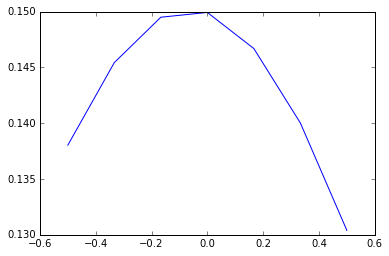

In [173]:
plt.plot(np.linspace(-.5,.5,NUM_SKILL_POINTS),ps[219]['Fairway-0']);

In [174]:
ps[30]

{'Bunker': array([ 0.13114657,  0.13216242,  0.1327757 ,  0.13298076,  0.1327757 ,
         0.13216242,  0.13114657]),
 'Fairway-0': array([ 0.1457433 ,  0.14968931,  0.15064043,  0.14853915,  0.14351224,
         0.1358581 ,  0.12601747]),
 'Fairway-300': array([ 0.12942484,  0.15188866,  0.1647844 ,  0.1652684 ,  0.15323097,
         0.13133673,  0.10406599]),
 'Fairway-540': array([ 0.17894257,  0.18123282,  0.17272773,  0.15491352,  0.13074305,
         0.10383647,  0.07760384]),
 'Green-0': array([ 0.09689636,  0.1318758 ,  0.16059631,  0.17499225,  0.17061409,
         0.14884141,  0.11618378]),
 'Green-10': array([ 0.07032292,  0.09618645,  0.1242054 ,  0.15141772,  0.17426996,
         0.18935554,  0.194242  ]),
 'Green-20': array([ 0.08837188,  0.11895502,  0.1468223 ,  0.16616588,  0.17243772,
         0.16408288,  0.14316433]),
 'Green-5': array([ 0.11985972,  0.1318278 ,  0.14173347,  0.14895995,  0.15303766,
         0.15369468,  0.15088672]),
 'Hole': array([ 0.13114657, 

In [25]:
len(to_compare)

115

In [26]:
np.mean([len(value) for key,value in to_compare.iteritems()])

1864.0434782608695

In [19]:
def partition (lst, n):
    return [lst[i::n] for i in xrange(n)]

In [ ]:
def run_a_day(year,round,course):
    data_ = data[(data.Year==year) & (data.Round==round) & (data['Course_#'])]
    grouped = data_.groupby(['Hole','Cat']):
    for tup,df in grouped:
        